# Redes residuais

Neste notebook, vamos explorar as **redes residuais**, uma arquitetura de redes neurais que facilita o treinamento de redes muito profundas. Veremos como as redes residuais superam problemas comuns, como o desaparecimento do gradiente, e entenderemos suas aplicações em tarefas de visão computacional. Por fim, vamos implementar uma rede residual para classificação.

## Configuração do ambiente

In [1]:
import os
import time
import numpy as np
import torch

from torch import nn
from torch import optim

from torch.utils.data import DataLoader
from torch.utils import data
from torch.backends import cudnn

from torchvision import models
from torchvision import datasets
from torchvision import transforms

from skimage import io

from sklearn import metrics

from matplotlib import pyplot as plt

%matplotlib inline

cudnn.benchmark = True

In [2]:
%load_ext nbproxy

Chave:  ewav
Senha: ········



Variáveis de ambiente http_proxy e https_proxy configuradas!


## Carregamento da base de dados

In [3]:
args = {
    'epoch_num': 50,
    'n_classes': 10,
    'lr': 1e-4,
    'weight_decay': 5e-4,
    'momentum': 0.9,
    'num_workers': 1,
    'batch_size': 200,
    'w_size': 224, # largura da imagem para redimensionar
    'h_size': 224, # altura da imagem para redimensionar
}

if torch.cuda.is_available():
    args['device'] = torch.device('cuda')
else:
    args['device'] = torch.device('cpu')

print(args['device'])

cuda


In [4]:
classes = ['plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']
classes_dict = {i : classes[i] for i in range(len(classes))}

Size of training set: 50000 samples
Size of test set: 10000 samples


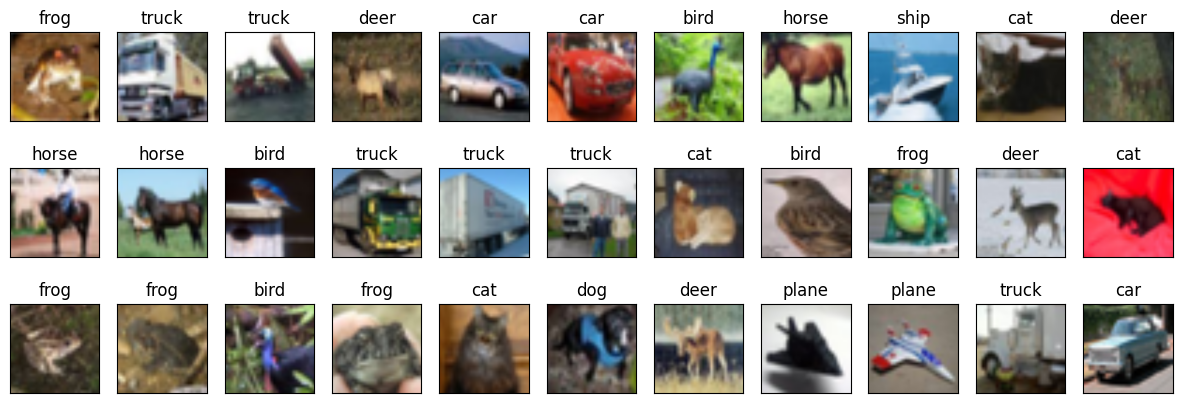

In [6]:
data_transform = transforms.Compose([
    transforms.Resize((args['h_size'], args['w_size'])),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

root = '/pgeoprj2/ciag2024/dados/cifar/'
train_set = datasets.CIFAR10(root,
                             train=True,
                             download=False,
                             transform=data_transform)

test_set = datasets.CIFAR10(root,
                            train=False,
                            download=False,
                            transform=data_transform)

train_loader = DataLoader(train_set,
                          args['batch_size'],
                          num_workers=args['num_workers'],
                          shuffle=True)

test_loader = DataLoader(test_set,
                         args['batch_size'],
                         num_workers=args['num_workers'],
                         shuffle=False)

print('Size of training set: ' + str(len(train_set)) + ' samples')
print('Size of test set: ' + str(len(test_set)) + ' samples')

fig, ax = plt.subplots(3, 11, figsize=(15, 5))

idx = 0
for i in range(3):
    for j in range(11):

        ax[i][j].imshow(train_set[idx][0].numpy().transpose((1,2,0)).squeeze())
        ax[i][j].set_title(classes_dict[train_set[idx][1]])
        ax[i][j].set_yticks([])
        ax[i][j].set_xticks([])
        idx += 1

plt.show()

## *ResNets*

Entre 2012 e 2015, a comunidade de Visão Computacional percebeu que redes mais profundas conseguiam capturar características semânticas mais úteis dos dados para tarefas de reconhecimento de imagens (i.e. classificação, segmentação, detecção etc). Porém, redes mais profundas que as maiores arquiteturas da época -- como a [VGG](https://arxiv.org/abs/1409.1556) e a [Inception](https://arxiv.org/abs/1409.4842) -- sofriam de um problema chamado **Vanishing Gradient**.

![VGG](https://www.researchgate.net/profile/Clifford_Yang/publication/325137356/figure/fig2/AS:670371271413777@1536840374533/llustration-of-the-network-architecture-of-VGG-19-model-conv-means-convolution-FC-means_W640.jpg)

![Inception](https://miro.medium.com/max/700/1*uW81y16b-ptBDV8SIT1beQ.png)


O **Vanishing Gradient** se torna mais problemático em redes mais profundas porque o gradiente dos erros precisa propagar desde a última camada até o começo da rede. Dessa forma, as últimas camadas conseguem ser treinadas de forma eficiente, mas o gradiente dos erros vai desaparecendo à medida em que backpropaga pela rede, praticamente impossibilitando o treinamento das primeiras camadas. Assim, foi constatado que uma rede com, por exemplo, 34 camadas acabava por conseguir resultados piores que uma rede com apenas 18 camadas.

![Rede Não Residual](https://lh4.googleusercontent.com/QOAWjplvdruwvPArIi3OSO22EVIklPiSHz2t-hduDO5Zr3JQb582K4hCjsxvkosZcNGq4dnnqN47LPAbGtDDjvH3o_F-f6bSMcnzpUHDi01DHsqrG0-TnjSk8G3SvgRIBgqzORVz)

Ao final de 2015 foi proposta uma solução para o **Vanishing Gradient** na forma de **Blocos Residuais** que, juntos, formam **Redes Residuais** [**(ResNets)**](https://arxiv.org/abs/1512.03385). Esses blocos residuais recebem uma entrada $x$ e a alimentam para um bloco convolucional $F$ composto por:

1.   Convolução 3x3;
2.   Batch Normalization;
3.   ReLU;
4.   Convolução 3x3;
5.   Batch Normalization.

A saída $F(x)$ desse bloco, antes de ser passada por uma segunda ReLU, é passada em conjunto com a entrada $x$ para uma função identidade, que, no caso das **ResNets**, é uma simples soma. Dessa forma, a saída final de um **Bloco Residual** é dada por: $F(x) + x$. O esquema de um **Bloco Residual** pode ser visto na figura abaixo.

![Bloco Residual](https://miro.medium.com/max/1140/1*D0F3UitQ2l5Q0Ak-tjEdJg.png)

Como pode ser visto na imagem a seguir, com o uso de blocos residuais, uma arquitetura com 34 camadas consegue resultados melhores que uma arquitetura com apenas 18 camadas. Esses resultados evidenciam que o uso da soma como **identity function** de fato permite que o backward treine mais efetivamente as primeiras camadas das **ResNets**. **ResNets** permitiram que CNNs chegassem até a casa das 100 camadas. A maior **ResNet** usada na prática possui 152 camadas, o que a deixa impraticável de imprimir numa figura como é mostrado abaixo na ResNet34.

![Rede Residual](https://lh4.googleusercontent.com/QOAWjplvdruwvPArIi3OSO22EVIklPiSHz2t-hduDO5Zr3JQb582K4hCjsxvkosZcNGq4dnnqN47LPAbGtDDjvH3o_F-f6bSMcnzpUHDi01DHsqrG0-TnjSk8G3SvgRIBgqzORVz)

Como pode ser visto nas imagens abaixo, ResNets (e outras arquiteturas modernas como a [VGG](https://arxiv.org/abs/1409.1556) e as [DenseNets](https://arxiv.org/abs/1608.06993) são compostas basicamente de convoluções com kernels de tamanho 3x3. Além disso, é notável na arquitetura residual (à direita) a presença dos "atalhos" para o gradiente  na forma das funções identidade que ajudam no treinamento das primeiras camadas durante o backpropagation.

![VGG vs. Plain34 vs. ResNet34](https://pic3.zhimg.com/v2-1f5e8b7816d2d31f2ac1342efb775a87_r.jpg)

### Atividade

Implemente as classes `ResidualBlock` e `ResNet18`.

In [ ]:
class ResidualBlock(nn.Module):

    def __init__(self, in_planes, out_planes):

        super(ResidualBlock, self).__init__()

        # Primeiro bloco convolucional
        self.conv1 = nn.Conv2d(in_planes,
                               out_planes,
                               kernel_size=3,
                               padding=1)
        self.bn1 = nn.BatchNorm2d(out_planes)

        # Segundo bloco convolucional
        self.conv2 = nn.Conv2d(out_planes,
                               out_planes,
                               kernel_size=3,
                               padding=1)
        self.bn2 = nn.BatchNorm2d(out_planes)

        # Ativação para os dois blocos
        self.relu = nn.ReLU(inplace=True)

        # Convolução 1x1 para igualar número de canais
        self.conv1x1 = None
        if in_planes != out_planes:
            self.conv1x1 = nn.Conv2d(in_planes, out_planes, kernel_size=1, padding=0)

    def forward(self, x):
        identity = x

        # Primeiro bloco convolucional
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        # Segundo bloco convolucional
        out = self.conv2(out)
        out = self.bn2(out)

        if self.conv1x1 is not None:
            identity = self.conv1x1(identity)

        out += identity # Soma da saída e identidade
        out = self.relu(out)

        return out

class ResNet18(nn.Module):

    def __init__(self, num_classes=10):

        super(ResNet18, self).__init__()

        self.conv1 = nn.Conv2d(3,
                               64,
                               kernel_size=7,
                               stride=2,
                               padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.res_block1 = ResidualBlock(64, 64)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.res_block2 = ResidualBlock(64, 128)
        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.adaptive_pool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.classifier = nn.Linear(128, num_classes)

        self.initialize_weights()

    def initialize_weights(self):

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):

        # Bloco convolucional
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool1(out)

        # Primeiro bloco residual
        out = self.res_block1(out)
        out = self.maxpool2(out)

        # Segundo bloco residual
        out = self.res_block2(out)
        out = self.maxpool3(out)

        # Adaptive average pooling para tamanho da saída 1x1
        out = self.adaptive_pool(out)

        # Linearizando dimensões finais
        out = out.view(x.size(0), -1)

        # Camada de inferência
        out = self.classifier(out)

        return out

net = ResNet18(args['n_classes']).to(args['device'])

print(net)

ResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (res_block1): ResidualBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (res_block2): ResidualBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

O Pytorch possui vários otimizadores prontos no subpacote [optim](https://pytorch.org/docs/stable/optim.html), desde o SGD básico a otimizadores mais complexos e com taxas de aprendizado por parâmetro como o Adagrad, RMSProp e Adam.

In [ ]:
optimizer = optim.Adam(net.parameters(),
                       lr=args['lr'],
                       betas=(args['momentum'], 0.999),
                       weight_decay=args['weight_decay'])

O subpacote [nn](https://pytorch.org/docs/stable/nn.html) possui várias funções de perda para diferentes tarefas (i.e. Cross Entropy, Negative Log Likelihood, loss L1, MSE, Kullback Leibler Divergence, etc) implementadas por padrão.



In [ ]:
criterion = nn.CrossEntropyLoss().to(args['device'])

### Treinamento e teste

Iterando sobre os datasets de treino e teste do CIFAR10. Abaixo são implementadas a função *train()* que itera sobre os batches do dataset de treino e atualiza o modelo e a função *test()* que apenas realiza o forward dos dados de teste no modelo e calcula a acurácia no dataset de teste para o modelo no estado atual.

In [ ]:
def train(train_loader, net, criterion, optimizer, epoch):
    tic = time.time()

    net.train()

    train_loss = []

    for i, batch_data in enumerate(train_loader):
        inps, labs = batch_data

        inps = inps.to(args['device'])
        labs = labs.to(args['device'])

        # Limpa os gradientes do otimizador
        optimizer.zero_grad()

        # Forward
        outs = net(inps)

        # Calcula perda
        loss = criterion(outs, labs)

        # Calcula backpropagation
        loss.backward()
        optimizer.step()

        train_loss.append(loss.data.item())

    toc = time.time()

    train_loss = np.asarray(train_loss)

    print('--------------------------------------------------------------------')
    print('[epoch %d], [train loss %.4f +/- %.4f], [training time %.2f]' % (
        epoch, train_loss.mean(), train_loss.std(), (toc - tic)))
    print('--------------------------------------------------------------------')

def test(test_loader, net, criterion, epoch):
    tic = time.time()

    net.eval()

    test_loss = []
    prd_list = []
    lab_list = []

    for i, batch_data in enumerate(train_loader):
        inps, labs = batch_data

        inps = inps.to(args['device'])
        labs = labs.to(args['device'])

        outs = net(inps)

        loss = criterion(outs, labs)

        prds = outs.data.max(dim=1)[1].cpu().numpy()

        test_loss.append(loss.data.item())
        prd_list.append(prds)
        lab_list.append(labs.detach().cpu().numpy())

    toc = time.time()

    acc = metrics.accuracy_score(np.asarray(lab_list).ravel(),
                                 np.asarray(prd_list).ravel())

    test_loss = np.asarray(test_loss)

    print('--------------------------------------------------------------------')
    print('[epoch %d], [test loss %.4f +/- %.4f], [acc %.4f], [testing time %.2f]' % (
        epoch, test_loss.mean(), test_loss.std(), acc, (toc - tic)))
    print('--------------------------------------------------------------------')

In [ ]:
for epoch in range(1, args['epoch_num'] + 1):

    train(train_loader, net, criterion, optimizer, epoch)

    test(test_loader, net, criterion, epoch)

--------------------------------------------------------------------
[epoch 1], [train loss 1.9203 +/- 0.1592], [training time 94.18]
--------------------------------------------------------------------
--------------------------------------------------------------------
[epoch 1], [test loss 1.7182 +/- 0.0436], [acc 0.3877], [testing time 82.80]
--------------------------------------------------------------------
--------------------------------------------------------------------
[epoch 2], [train loss 1.6175 +/- 0.0753], [training time 94.74]
--------------------------------------------------------------------
--------------------------------------------------------------------
[epoch 2], [test loss 1.5699 +/- 0.0564], [acc 0.4421], [testing time 82.86]
--------------------------------------------------------------------
--------------------------------------------------------------------
[epoch 3], [train loss 1.4626 +/- 0.0653], [training time 95.84]
------------------------------